In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
def plot_distribution(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Tokens")
    # fig.show()
    
    
def plot_alignment(project_df):    
    fig, ax = plt.subplots(figsize=(8,5))
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax)
    ax.set_ylabel("Tokens")
    ax.set_xlabel("Impact")
    ax.set_xticks([])    
    # fig.show()

def plot_all(project_df, save_fp=None):
    fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    project_df['token_amount'].plot(kind='bar', width=1, ax=ax[0])
    project_df.plot(kind='scatter', x='rating', y='token_amount', ax=ax[1])
    ax[0].set_xticks([])
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Pct Tokens Allocated")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Impact")
    ax[1].set_xticks([])
    plt.tight_layout()
    if save_fp:
        plt.savefig(save_fp)
    
    
def analyze_simulation(results, generate_plots=False):
    summary = pd.Series(results).iloc[:-1].apply(lambda x: int(x) if isinstance(x, float) else x)
    data = results['data']
    project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
    if generate_plots:
        plot_all(project_df)
    return summary

### Normalize to the voting that we will be doing (100 votes)

In [4]:
## Num Projects > Quorum when sweeping Quorum
quorum_vec = list(np.arange(1, 25+1))
score_fn = ['mean']  # note quorum doesnt depend on score fn
sim_configs = list(itertools.product(quorum_vec, score_fn))

project_pass_vec = []
for sim_config in tqdm(sim_configs):
    q, score_fn = sim_config
    simulation = Simulation()

    simulation.initialize_round(
        max_funding=100,
    )
    simulation.randomize_voters(
        num_voters=50, 
        willingness_to_spend=1.0, 
        laziness_factor=0.1, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=137
    )

    results = simulation.simulate_voting_and_scoring(
        n=100,
        scoring_method=score_fn,
        quorum=q,
        min_amount=1,
        normalize=True
    )
    summary = analyze_simulation(results, generate_plots=False)
    project_pass_vec.append(summary.num_projects_above_quorum)


  0%|          | 0/25 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effect of Quorum on the Number of Funded Projects \n Total Projects = 137')

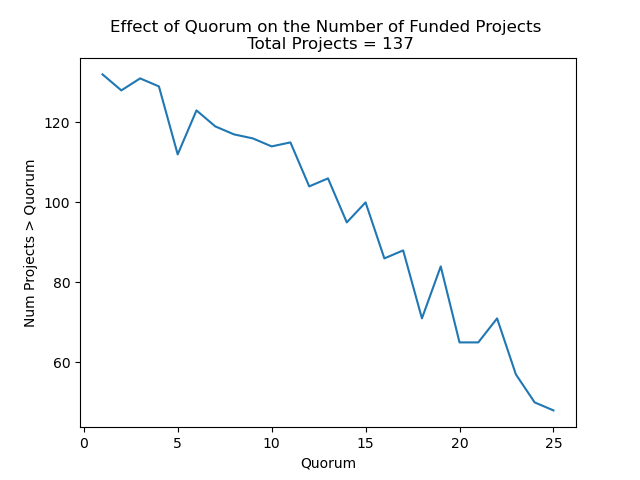

In [5]:
plt.figure()
plt.plot(quorum_vec, project_pass_vec)
plt.xlabel('Quorum')
plt.ylabel('Num Projects > Quorum')
plt.title('Effect of Quorum on the Number of Funded Projects \n Total Projects = 137')

In [14]:
## Num Projects > Quorum when sweeping Quorum
score_fn = ['mean', 'median', 'quadratic']
quorum_vec = list(np.arange(1, 10+1))
laziness_vec = [0.1, 0.3]
num_voters_vec = [25, 50]

sim_configs = list(itertools.product(quorum_vec, score_fn, laziness_vec, num_voters_vec))

pass_results = []
for sim_config in tqdm(sim_configs):
    q, score_fn, laziness, num_voters = sim_config
    simulation = Simulation()

    simulation.initialize_round(
        max_funding=100,
    )
    simulation.randomize_voters(
        num_voters=num_voters, 
        willingness_to_spend=1.0, 
        laziness_factor=laziness, 
        expertise_factor=0.9
    )
    simulation.randomize_projects(
        num_projects=137
    )

    results = simulation.simulate_voting_and_scoring(
        n=20,
        scoring_method=score_fn,
        quorum=q,
        min_amount=1,
        normalize=True
    )
    try:
        summary = analyze_simulation(results, generate_plots=False)
        data = results['data']
        project_df = pd.DataFrame(data).sort_values(by='token_amount', ascending=False)
        pass_results.append({
            'quorum': q,
            'score_fn': score_fn,
            'project_df': project_df,
            'laziness': laziness,
            'num_voters': num_voters,
        })
    except Exception as e:
        print(f"Failed for {sim_config}")
        raise e
        # pass_results.append({
        #     'quorum': q,
        #     'score_fn': score_fn,
        #     'project_df': None,
        #     'laziness': laziness,
        #     'num_voters': num_voters,
        # })
        # continue

  0%|          | 0/120 [00:00<?, ?it/s]

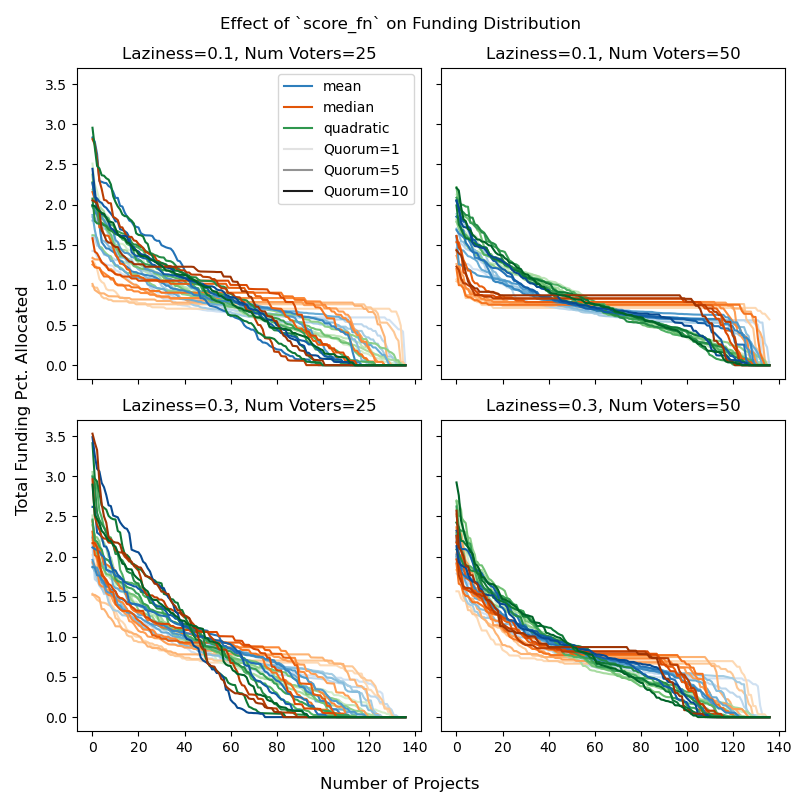

In [29]:
fig,ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
# plt.figure()
cmap_means = mpl.colormaps['Blues']
cmap_medians = mpl.colormaps['Oranges']
cmap_quadratics = mpl.colormaps['Greens']
cmap_access_vec = np.linspace(0.2, 0.9, len(quorum_vec))

for p in pass_results:
    q = p['quorum']
    l = p['laziness']
    n = p['num_voters']
    ix0 = laziness_vec.index(l)
    ix1 = num_voters_vec.index(n)
    axx = ax[ix0, ix1]
    cmap_ix = cmap_access_vec[quorum_vec.index(q)]
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_ix)
        axx.plot(p['project_df']['token_amount'].values, color=cc)
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_ix)
        axx.plot(p['project_df']['token_amount'].values, color=cc)
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_ix)
        axx.plot(p['project_df']['token_amount'].values, color=cc)
    axx.set_title(f'Laziness={l}, Num Voters={n}')
    

greys = mpl.colormaps['Greys']
ax[0,0].plot(0,0, color=cmap_means(0.7), label='mean')
ax[0,0].plot(0,0, color=cmap_medians(0.7), label='median')
ax[0,0].plot(0,0, color=cmap_quadratics(0.7), label='quadratic')
ax[0,0].plot(0,0, color=greys(0.2), label='Quorum=1')
ax[0,0].plot(0,0, color=greys(cmap_access_vec[4]), label='Quorum=5')
ax[0,0].plot(0,0, color=greys(0.9), label='Quorum=10')
ax[0,0].legend()

fig.supxlabel('Number of Projects')
fig.supylabel('Total Funding Pct. Allocated')
plt.suptitle('Effect of `score_fn` on Funding Distribution')
plt.tight_layout()
plt.savefig('score_fn_effect.png')

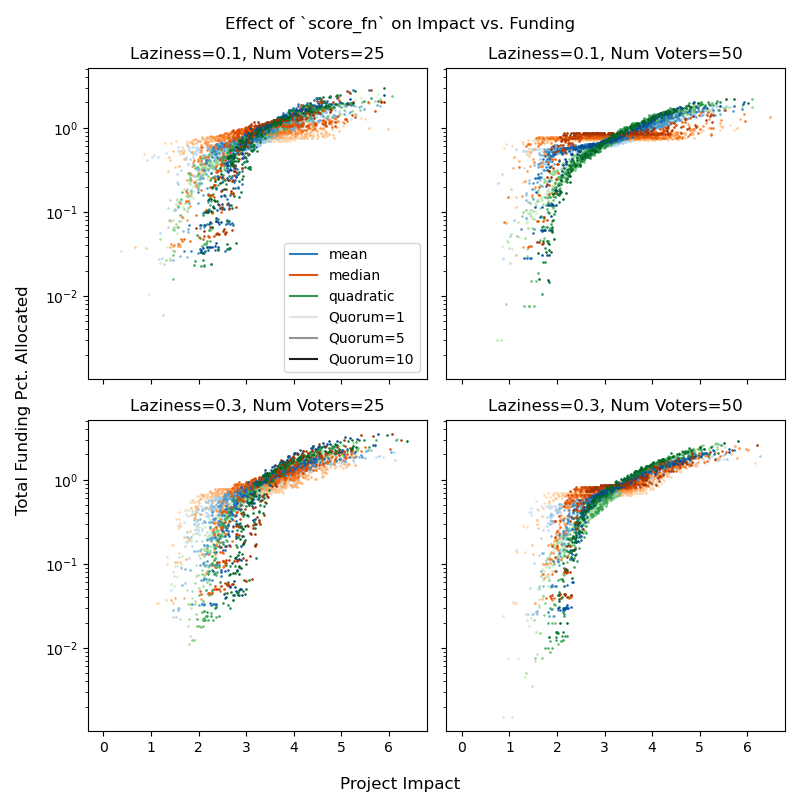

In [32]:
fig,ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
# plt.figure()
cmap_means = mpl.colormaps['Blues']
cmap_medians = mpl.colormaps['Oranges']
cmap_quadratics = mpl.colormaps['Greens']
cmap_access_vec = np.linspace(0.2, 0.9, len(quorum_vec))

for p in pass_results:
    q = p['quorum']
    l = p['laziness']
    n = p['num_voters']
    ix0 = laziness_vec.index(l)
    ix1 = num_voters_vec.index(n)
    axx = ax[ix0, ix1]
    cmap_ix = cmap_access_vec[quorum_vec.index(q)]
    if p['score_fn'] == 'mean':
        cc = cmap_means(cmap_ix)
        axx.scatter(p['project_df']['rating'].values, p['project_df']['token_amount'].values, color=cc, s=0.75)
    elif p['score_fn'] == 'median':
        cc = cmap_medians(cmap_ix)
        axx.scatter(p['project_df']['rating'].values, p['project_df']['token_amount'].values, color=cc, s=0.75)
    elif p['score_fn'] == 'quadratic':
        cc = cmap_quadratics(cmap_ix)
        axx.scatter(p['project_df']['rating'].values, p['project_df']['token_amount'].values, color=cc, s=0.75)
    axx.set_title(f'Laziness={l}, Num Voters={n}')
    

greys = mpl.colormaps['Greys']
ax[0,0].plot(0,0, color=cmap_means(0.7), label='mean')
ax[0,0].plot(0,0, color=cmap_medians(0.7), label='median')
ax[0,0].plot(0,0, color=cmap_quadratics(0.7), label='quadratic')
ax[0,0].plot(0,0, color=greys(0.2), label='Quorum=1')
ax[0,0].plot(0,0, color=greys(cmap_access_vec[4]), label='Quorum=5')
ax[0,0].plot(0,0, color=greys(0.9), label='Quorum=10')
ax[0,0].legend()

ax[0,0].set_yscale('log')

fig.supxlabel('Project Impact')
fig.supylabel('Total Funding Pct. Allocated')
plt.suptitle('Effect of `score_fn` on Impact vs. Funding')
plt.tight_layout()
plt.savefig('score_fn_sweep.png')